**This is Fake news generator where we use LSTM  ✈**

In [63]:
#importing basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
df=pd.read_csv('train.csv',on_bad_lines='skip',engine='python') #the file contains some unnecessary data

In [65]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20822 entries, 0 to 20821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20822 non-null  object
 1   title   20257 non-null  object
 2   author  18847 non-null  object
 3   text    20763 non-null  object
 4   label   20800 non-null  object
dtypes: object(5)
memory usage: 813.5+ KB


In [67]:
df.isnull().sum()

,0
id,0
title,565
author,1975
text,59
label,22


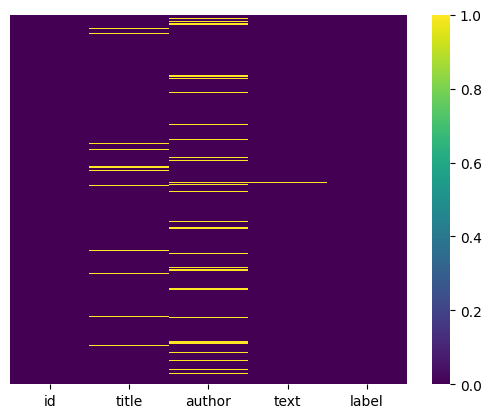

In [68]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')
plt.show()

From this we can understand we have lot null values in author and title columns

In [69]:
df.shape

(20822, 5)

In [70]:
df=df.dropna()

In [71]:
df['label'].unique()

array(['1', '0', ' как люди воспринимают своё положение.',
       ' чтобы это была дорога с двусторонним движением.'], dtype=object)

Removing unwanted text from label

In [72]:
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# Drop rows where 'label' is NaN or not in [0, 1]
df = df[df['label'].isin([0, 1])]

# Convert 'label' back to int if needed
df['label'] = df['label'].astype(int)

<ipython-input-72-1d5b3f27b481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = pd.to_numeric(df['label'], errors='coerce')


In [73]:
#after removing null data
df.shape

(18283, 5)

In [74]:
df['label'].unique()

array([1, 0])

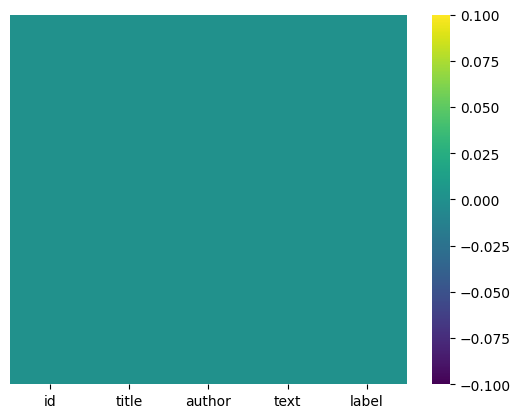

In [75]:
#now we can see there is no null data
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')
plt.show()

In [76]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [77]:
X=df.drop(columns='label',axis=1)

In [78]:
Y=pd.DataFrame(df['label'])

In [79]:
t=df['label'].value_counts()
print(t.index)
print(t.values)

Index([0, 1], dtype='int64', name='label')
[10361  7922]


In [80]:
df['label'].value_counts()

,count
label,
0,10361
1,7922


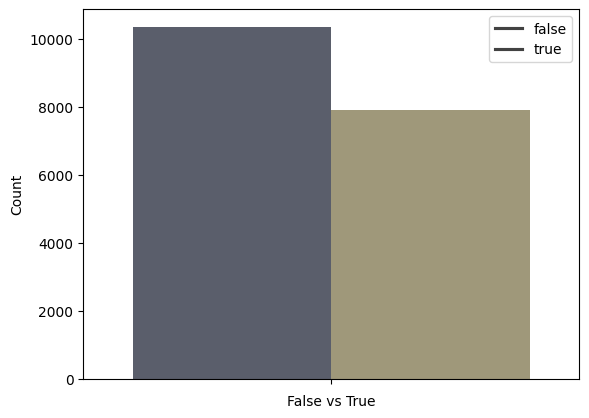

In [81]:
sns.barplot(hue=t.index,y=t.values,palette='cividis')
plt.xlabel('False vs True')
plt.ylabel('Count')
plt.legend(['false','true'])
plt.show()

**importing neural networks and LSTM**

In [82]:
#importing neural networks and LSTM

from tensorflow.keras.layers import Embedding,InputLayer,LSTM,Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [83]:
messages=X.copy()

In [84]:
messages['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

**importing nltk packages**

In [85]:
import nltk
import re
from nltk.corpus import stopwords

In [86]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data Preprocessing**

In [87]:
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps=PorterStemmer()

stop_words=set(stopwords.words('english'))
corpus=[]

for i,row in messages.iterrows():  ## using this instead range helps in proper row iteration and more robust
  linewords=re.sub('[^a-zA-Z0-9]',' ',messages['title'][i])
  linewords=linewords.lower()
  linewords=linewords.split()

  linewords=[ps.stem(word) for word in linewords if not word in stop_words]
  linewords=' '.join(linewords)
  corpus.append(linewords)

Got good data so we can apply **one hot encoding**

In [88]:
#vocabulary size (unique words)
voc_size=7000

In [89]:
onehotwords=[one_hot(word,voc_size) for word in corpus]
onehotwords[0]

[2592, 2982, 546, 5699, 1779, 5072, 6729, 1091, 6034, 1377]

Now as it is diff in size we use **padding** using encoding

In [90]:
step_words=20
padding_words=pad_sequences(onehotwords,maxlen=step_words,padding='pre')

In [91]:
padding_words[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2592,
       2982,  546, 5699, 1779, 5072, 6729, 1091, 6034, 1377], dtype=int32)

Creating model with **Embedding** and **LSTM**

In [92]:
## output of padding is given into model as input here it is in 20 vectors
vector_features=40 ##features representation dimensions like google 300 dimension
model=Sequential()
model.add(InputLayer(input_shape=(step_words,)))
model.add(Embedding(input_dim=voc_size,output_dim=vector_features))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 20, 40)              │         280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          56,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,501 (1.28 MB)

 Trainable params: 336,501 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

None


converting list to arrays

In [93]:
X_final=np.array(padding_words)
y_final=np.array(Y)

In [94]:
X_final.shape,y_final.shape

((18283, 20), (18283, 1))

In [95]:
y_final.dtype

dtype('int64')

**Train test split**

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.3,random_state=42)

**Model Training**

In [98]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=8,batch_size=64)

Epoch 1/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7696 - loss: 0.4252 - val_accuracy: 0.9147 - val_loss: 0.1935
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9505 - loss: 0.1311 - val_accuracy: 0.9227 - val_loss: 0.1875
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9726 - loss: 0.0769 - val_accuracy: 0.9198 - val_loss: 0.2008
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9830 - loss: 0.0556 - val_accuracy: 0.9170 - val_loss: 0.2707
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9883 - loss: 0.0369 - val_accuracy: 0.9160 - val_loss: 0.2756
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9912 - loss: 0.0270 - val_accuracy: 0.9134 - val_loss: 0.3838
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9964 - loss: 0.0150 - val_accuracy: 0.9118 - val_loss: 0.4387
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9974 - loss: 0.0090 - val_accura

**Performance Metrics and Accuracy**

In [99]:
y_pred=model.predict(X_test)

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [100]:
y_pred=np.where(y_pred >0.5,1,0)

In [101]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9159525979945305

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      3130
           1       0.88      0.94      0.91      2355

    accuracy                           0.92      5485
   macro avg       0.91      0.92      0.91      5485
weighted avg       0.92      0.92      0.92      5485

